## Data Import

<IPython.core.display.Javascript object>


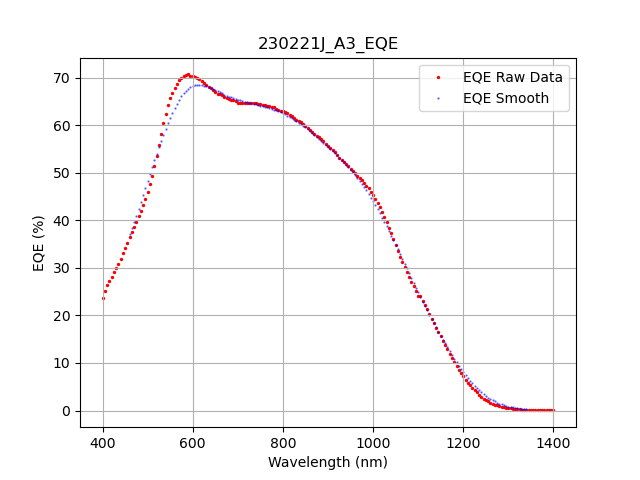

In [86]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from IPython.display import display
import ipywidgets as widgets
from scipy.integrate import cumtrapz
import matplotlib.ticker as ticker

# Enable interactive plots in Jupyter Notebook
%matplotlib nbagg

# Set the path to the foldercontaining text files
folder_path = "C:\\Users\\w16025698\\OneDrive - Northumbria University - Production Azure AD\\PhD\\Characterisation\\EQE\\230221_EQE"
file_name = "230221J_A3_EQE.txt"
file_title = file_name.replace('.txt', '')

# Solar Iradiance data
solar_irradiance_path = "C:\\Users\\w16025698\\OneDrive - Northumbria University - Production Azure AD\\PhD\\Characterisation\\EQE\\Jsc from EQE calc.xlsx"
irradiance_df = pd.read_excel(solar_irradiance_path, sheet_name='Sheet2', skiprows=1)

# Read the data from the text file, skipping the first lines
df = pd.read_csv(os.path.join(folder_path, file_name), sep="\t", header=None, names=["Wavelength", "EQE"])

# Merge the columns based on the "Wavelength" column
merged_df = df.merge(irradiance_df[['Wavelength', 'number of photons per m2 per second']], on='Wavelength')

# Apply moving average filter to EQE data
window_size = 25
merged_df['EQE_smooth'] = merged_df['EQE'].rolling(window_size, center=True).mean()

# Plot the data
plt.scatter(merged_df['Wavelength'], merged_df['EQE'], s=2, c='r', label='EQE Raw Data')
plt.scatter(merged_df['Wavelength'], merged_df['EQE_smooth'], s=0.5, c='b', alpha=0.5, label='EQE Smooth')
plt.xlabel('Wavelength (nm)')
plt.ylabel('EQE (%)')
plt.legend()
plt.title(file_title)
plt.grid()

## Jsc from EQE Calculation

In [87]:
# Perform the multiplication for corresponding wavelengths
merged_df['Jsc (mA/cm2)'] = merged_df['EQE']*merged_df['number of photons per m2 per second'] *0.001*1.6E-19
# Calculate the integrated Jsc
merged_df['Integrated Jsc'] = np.cumsum(merged_df['Jsc (mA/cm2)'])


## Band Gap Calculation

<IPython.core.display.Javascript object>


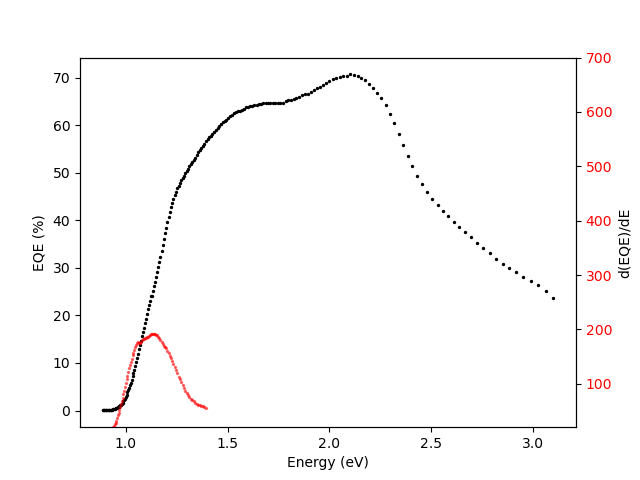

Maximum deqe value in masked data: 191.94894538709377
Electronic Band Gap: 1.1324200913242009


In [88]:
merged_df['hv'] = 1240/merged_df['Wavelength']
merged_df['grad'] = np.gradient(np.abs(merged_df['EQE_smooth']), merged_df['hv'])

# Masked Data
x_min = 0.8
x_max = 1.4
mask = np.logical_and(merged_df['hv'] >= x_min, merged_df['hv'] <= x_max)
hv_subset = merged_df['hv'][mask]
deqe_subset = merged_df['grad'][mask]

# Plot
fig, ax1 = plt.subplots()
ax1.scatter(merged_df['hv'], merged_df['EQE'], s=2, c='k')
ax1.set_xlabel('Energy (eV)')
ax1.set_ylabel('EQE (%)')
#ax1.set_xlim(1.0,2)

ax2 = ax1.twinx()
ax2.scatter(hv_subset, deqe_subset, c='r', s=2, alpha=0.5, label='d(EQE)/dE')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylabel('d(EQE)/dE')
ax2.set_ylim(20, 700)
#ax2.set_xlim(1.0,2)

# Calculate maximum deqe value and it's index in the masked data
max_deqe = np.max(deqe_subset)
max_deqe_index = np.argmax(deqe_subset)

# Get the corresponding hv_subset value
band_gap = hv_subset.iloc[max_deqe_index]

# Print the maximum deqe value and its corresponding hv_subset value
print("Maximum deqe value in masked data:", max_deqe)
print("Electronic Band Gap:", band_gap)

<IPython.core.display.Javascript object>


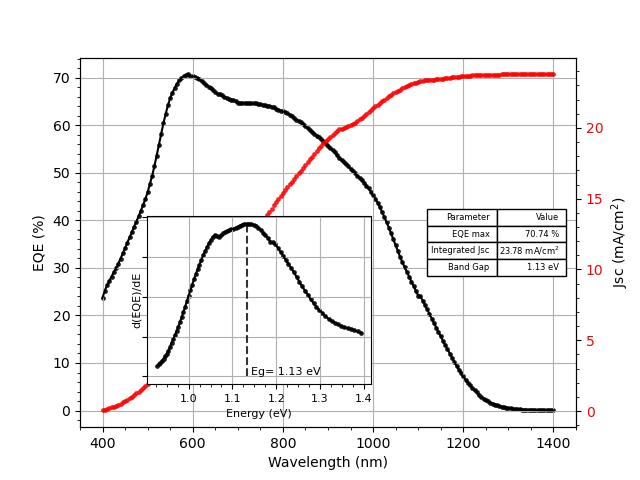

In [113]:
# Plot the data
fig, ax1 = plt.subplots()

ax1.scatter(merged_df['Wavelength'], merged_df['EQE'], s=6, c='k', alpha=0.8)
ax1.plot(merged_df['Wavelength'], merged_df['EQE'], c='k')
ax1.set_ylabel('EQE (%)')
ax1.set_xlabel('Wavelength (nm)')
ax1.grid()
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(50))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(2))
ax1.xaxis.set_tick_params(which='both', labelbottom=True)
ax1.yaxis.set_tick_params(which='both', labelbottom=True)

ax2 = ax1.twinx()
ax2.scatter(merged_df['Wavelength'], merged_df['Integrated Jsc'], s=6, c='r', alpha=0.8)
ax2.set_ylabel('Jsc (mA/cm$^2$)')
ax2.tick_params(axis='y', labelcolor='red')
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(1))

# Add a table with parameters
table_data = [
    ['Parameter', 'Value'],
    ['EQE max', "{:.2f}".format(np.max(merged_df['EQE'])) + ' %'],
    ['Integrated Jsc', "{:.2f}".format(np.max(merged_df['Integrated Jsc'])) + ' mA/cm$^2$'],
    ['Band Gap', "{:.2f}".format(band_gap) + ' eV']
]

table = plt.table(cellText=table_data, colWidths=[0.35, 0.35], loc='center right')
table.auto_set_font_size(False)
table.set_fontsize(6)
table.scale(0.4, 1.0)

# Create a second axes for the additional plot in the top right corner
ax3 = fig.add_axes([0.23, 0.2, 0.35, 0.35])  # Adjust the position and size as needed

ax3.scatter(hv_subset, deqe_subset, label='d(EQE)/dE', s=6, c='k', alpha=0.8)
ax3.plot(hv_subset, deqe_subset, c='k')
ax3.tick_params(axis='y', labelleft= False)
ax3.tick_params(axis='x', labelsize=8)
ax3.set_ylabel('d(EQE)/dE', fontsize=8)
ax3.set_xlabel('Energy (eV)', fontsize=8)
ax3.xaxis.set_minor_locator(ticker.MultipleLocator(0.025))
ax3.vlines(band_gap, 0, max_deqe, colors='k', linestyles='--', alpha=0.8)
ax3.grid()

ax3.text(band_gap + 0.01, 2, "Eg= {:.2f} eV".format(band_gap), fontsize=8)

plt.show()

save_dir = os.path.join(folder_path, 'EQE Plots')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save the plot as an image file
plt.savefig(os.path.join(save_dir, file_title + '.png'), dpi=500)

<IPython.core.display.Javascript object>


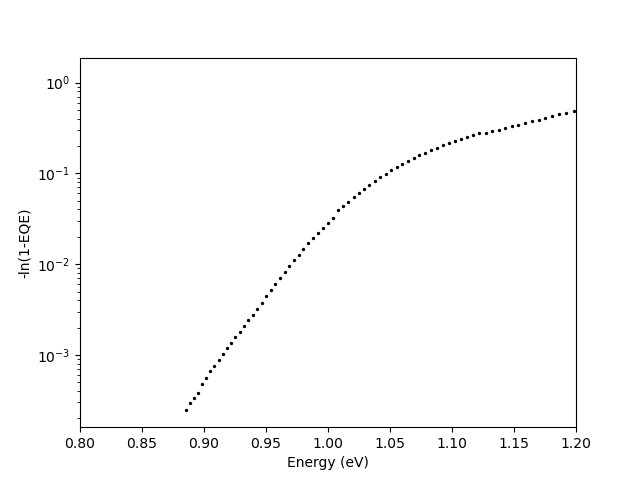

(0.8, 1.2)

In [4]:
# Plot
fig, ax = plt.subplots()
ax.scatter(merged_df['hv'], merged_df['log'], s=2, c='k')
ax.set_xlabel('Energy (eV)')
ax.set_ylabel('-ln(1-EQE)')
ax.set_yscale('log')
ax.set_xlim(0.8,1.2)